## Laboratorium 7.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od zlokalizowania jakichś obiektów, być może z góry wiemy, gdzie obiekty się znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie nie będzie jednak centralne na laboratorium.

---

In [2]:
from typing import List
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Zadanie 1

#### Zadanie 1a

Dany jest plik `amsterdam47.mp4` przedstawiający zapis ruchu na skrzyżowaniu. Uzupełnij podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii obiektów, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie znalezionych obiektów). Niekoniecznie musisz przetwarzać cały materiał wideo - zwróć uwagę, że pojazdy znikają poza klatką, uniemożliwiając ich dalsze śledzenie.

In [3]:
def baseLoop(video_name: str, checkpoint_step: int):
    """Performs tracking of features across the frames"""

    source = cv2.VideoCapture(video_name)

    status, frame1 = source.read()
    status, frame2 = source.read()
    frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY) 

    locations = [cv2.goodFeaturesToTrack(frame1, 150, 0.01, 10).squeeze()]
    checkpoints_frames = [frame1]
    step = 0
    
    while status:
        
        # Run optical flow
        frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        new_locations, _, _ = cv2.calcOpticalFlowPyrLK(frame1, frame2, locations[-1], None)
        locations.append(new_locations)

        # Append checkpoint frames
        step += 1
        if step % checkpoint_step == 0:
            checkpoints_frames.append(frame2)

        # Read next frame
        frame1 = frame2
        status, frame2 = source.read()

    end_frame = frame1.copy()
        
    return np.array(locations), checkpoints_frames


def visualize_trajectories(video_name: str, checkpoint_step: int):
    """Visualizes trajectories of tracked objects across the frames"""

    localization, checkpoint_frames = baseLoop(video_name, checkpoint_step)

    fig, axes = plt.subplots(2, len(checkpoint_frames), figsize=(30, 10))
    point_paths = np.transpose(localization, (1, 0, 2))

    for i, ax in enumerate(axes.T):
        current_frame = checkpoint_frames[i]
    
        canvas = np.zeros_like(current_frame)

        # Plot all motion on first column
        if  i == 0:
            for point_path in point_paths:
                canvas = cv2.polylines(canvas, [point_path.astype(np.int32)], False, (100, 100, 100), 2)
        
            ax[0].imshow(current_frame)
            ax[1].imshow(canvas)

            ax[0].axis("off")
            ax[1].axis("off")

            ax[0].set_title(f"Frame {i * checkpoint_step}")
            ax[1].set_title(f"Whole motion")
        
        # Plot motion between frames
        else:
            for point_path in point_paths[:, (i - 1) * checkpoint_step : i * checkpoint_step]:
                canvas = cv2.polylines(canvas, [point_path.astype(np.int32)], False, (50, 50, 50), 2)
        
            ax[0].imshow(current_frame)
            ax[1].imshow(canvas)

            ax[0].axis("off")
            ax[1].axis("off")

            ax[0].set_title(f"Frame {i * checkpoint_step}")
            ax[1].set_title(f"Motion between frames: {(i - 1) * checkpoint_step}-{i * checkpoint_step}")

        ax[0].axis("off")
        ax[1].axis("off")

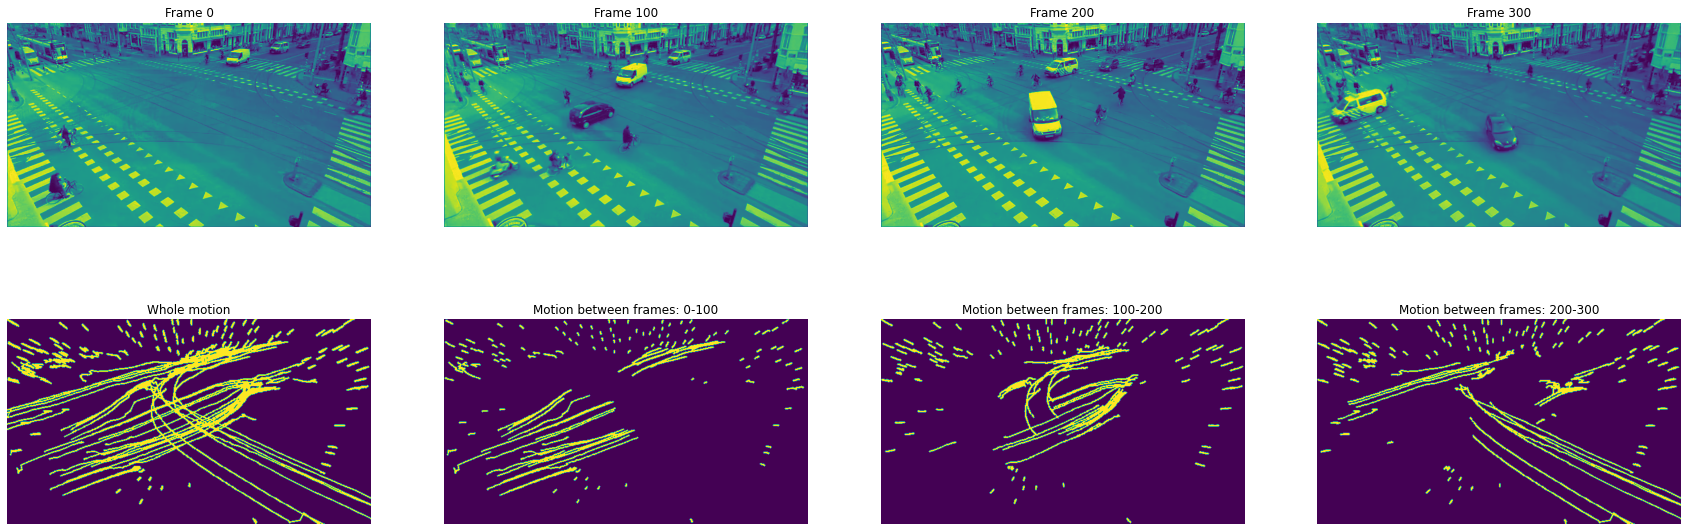

In [4]:
visualize_trajectories("dane/amsterdam47.mp4", 100)

W znalezionych trajektoriach widzimy trochę artefaktów tła oraz sytuacje opisaną we wstępie - detekcja interesujących obiektów odbywa się na pierwszej klatce zatem brakuje śledzenia obiektów pojawiających się w kolejnych klatkach.

#### Zadanie 1b

Powtórz poprzednie doświadczenie na różnych fragmentach materiału źródłowego. Kiedy i w jaki sposób metoda zawodzi?

In [7]:
def baseLoopSkip(video_name: str, skip_frames: int):
    """Performs tracking of features across the frames with skipping first n-frames"""

    source = cv2.VideoCapture(video_name)

    # Skipping frames
    for _ in range(skip_frames):
        status, frame1 = source.read()

    status, frame1 = source.read()
    status, frame2 = source.read()
    frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY) 
    start_frame = frame1.copy()

    locations = [cv2.goodFeaturesToTrack(frame1, 150, 0.01, 10).squeeze()]
    
    while status:
        
        # Run optical flow
        frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        new_locations, _, _ = cv2.calcOpticalFlowPyrLK(frame1, frame2, locations[-1], None)
        locations.append(new_locations)

        # Read next frame
        frame1 = frame2
        status, frame2 = source.read()
        
    return np.array(locations), start_frame


def visualize_skip_trajectories(video_name: str, skip_frames_list: List[int]):
    """Visualizes trajectories of tracked objects across the frames with re-localization"""

    fig, axes = plt.subplots(2, len(skip_frames_list), figsize=(30, 10))

    for ax, skip_frames in zip(axes.T, skip_frames_list):
        localization, start_frame = baseLoopSkip(video_name, skip_frames)
        point_paths = np.transpose(localization, (1, 0, 2))
    
        canvas = np.zeros_like(start_frame)

        for point_path in point_paths:
            canvas = cv2.polylines(canvas, [point_path.astype(np.int32)], False, (100, 100, 100), 2)
    
        ax[0].imshow(start_frame)
        ax[1].imshow(canvas)

        ax[0].axis("off")
        ax[1].axis("off")

        ax[0].set_title(f"Frame {skip_frames}")
        ax[1].set_title(f"Motion with frame {skip_frames} re-localization")

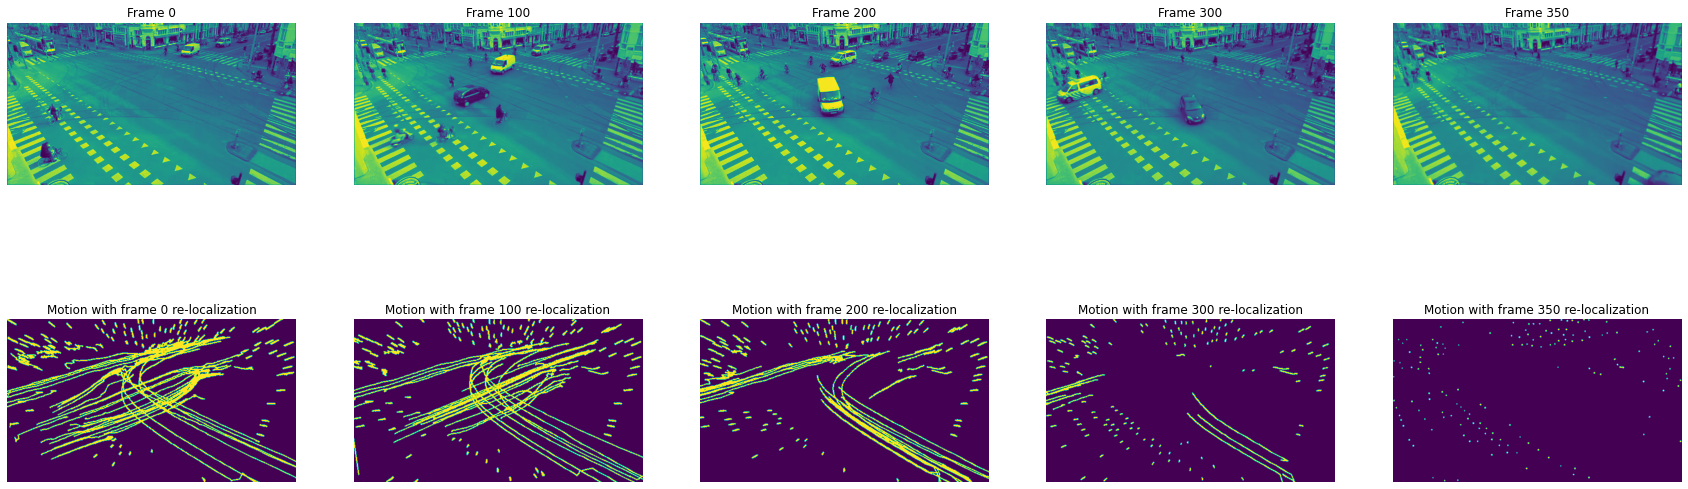

In [9]:
visualize_skip_trajectories("dane/amsterdam47.mp4", [0, 100, 200, 300, 350])

Komentarz 1:

Z re-lokalizacją w trakcie trwania video widzimy, że dokonuje się detekcja pojazdów, których nie było na pierwszej klatce (lub były bardzo małe głównie w tle - czarny samochód) i są one śledzone.

### Zadanie 2

Wykorzystując historię położenia poszczególnych obiektów, zidentyfikuj punkty należące do tła i odfiltruj je ze zbioru śledzonych obiektów.  
*Jeśli starczy czasu:* zidentyfikuj punkty należące do tych samych obiektów (tj. poruszające się w ten sam sposób).

In [20]:
def visualize_filter_skip_trajectories(video_name: str, skip_frames_list: List[int], motion_ths: List[float]):
    """
    Visualizes trajectories of tracked objects across the frames 
    with re-localization and filtering of background motion.
    """

    fig, axes = plt.subplots(len(motion_ths) + 1, len(skip_frames_list), figsize=(30, 20))

    for ax, skip_frames in zip(axes.T, skip_frames_list):
        localization, start_frame = baseLoopSkip(video_name, skip_frames)
        point_paths = np.transpose(localization, (1, 0, 2))

        for i, motion_th in enumerate(motion_ths):
            canvas = np.zeros_like(start_frame)

            for point_path in point_paths:
                diff = np.linalg.norm(point_path[:-1] - point_path[1:], axis=1).mean()

                if diff > motion_th:
                    canvas = cv2.polylines(canvas, [point_path.astype(np.int32)], False, (100, 100, 100), 2)

            ax[i + 1].imshow(canvas)
            ax[i + 1].axis("off")
            ax[i + 1].set_title(f"BG motion filter threshold: {motion_th}")
    
        ax[0].imshow(start_frame)
        ax[0].axis("off")
        ax[0].set_title(f"Frame {skip_frames}")

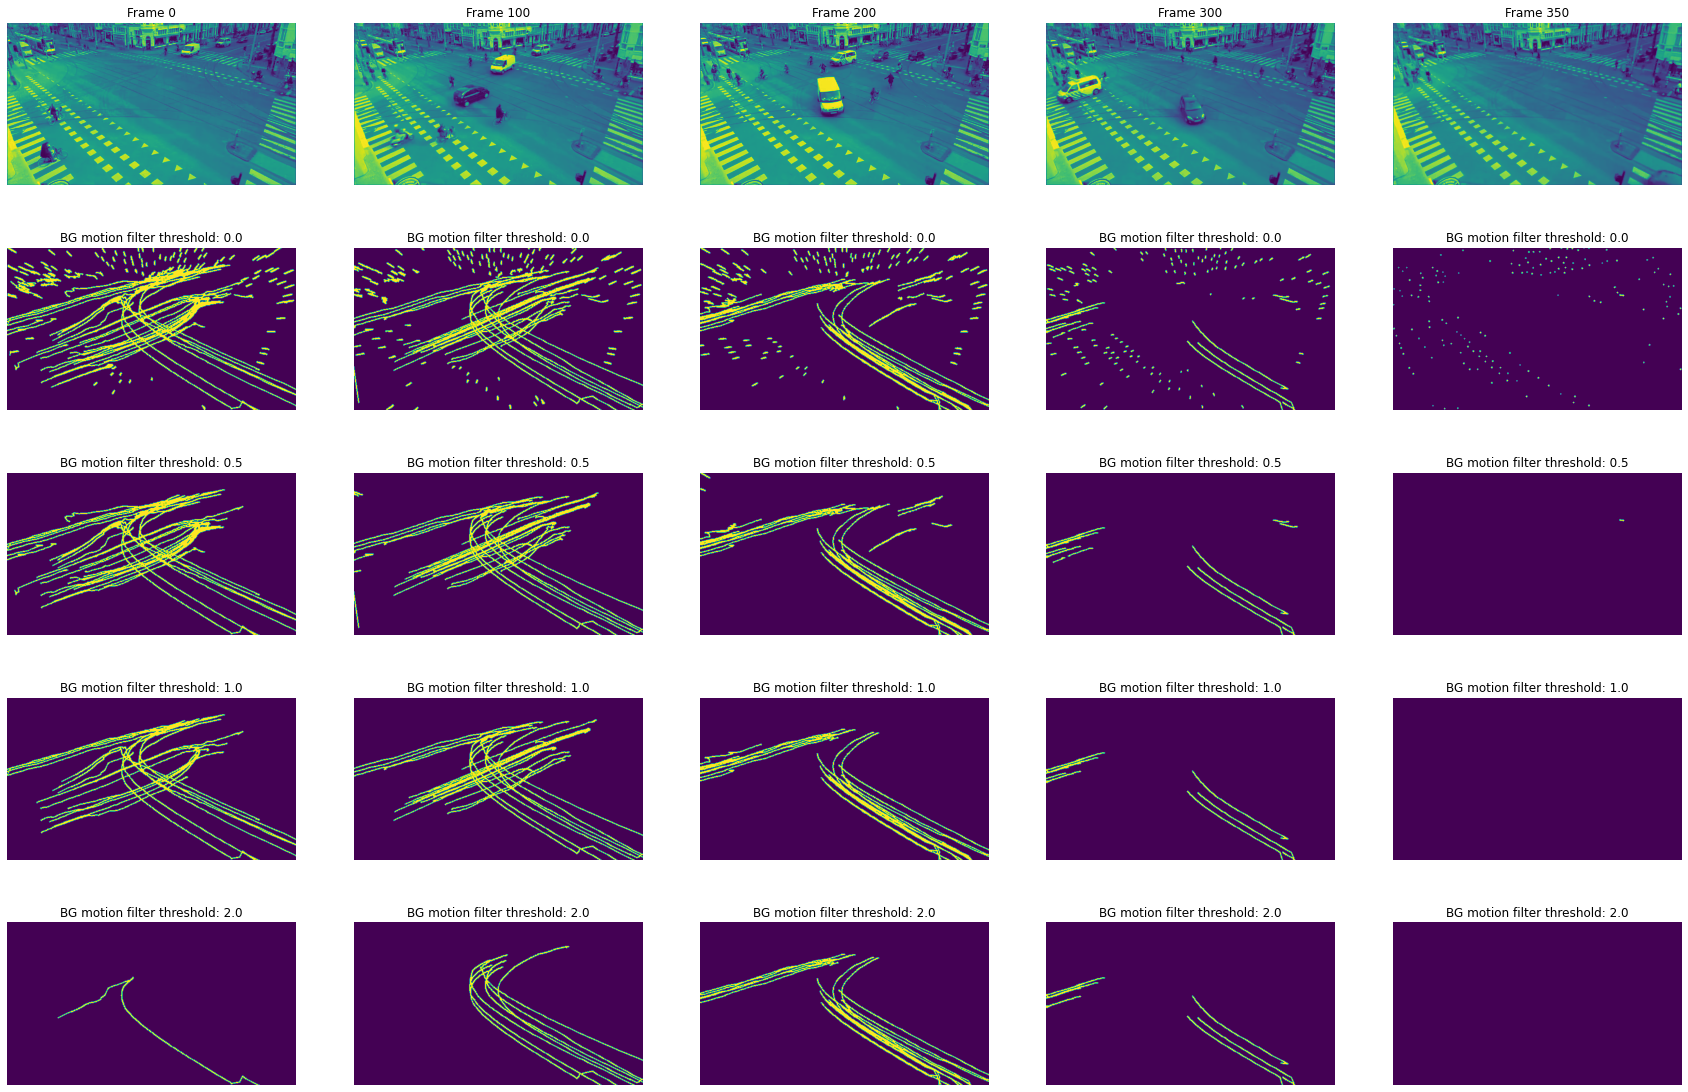

In [21]:
visualize_filter_skip_trajectories("dane/amsterdam47.mp4", [0, 100, 200, 300, 350], [0.0, 0.5, 1.0, 2.0])

Punkty tła są identyfikowane jako te, których średni ruch pomiędzy klatkami jest mniejszy niż podany próg. Jak widzimy po wynikach, dla progu $0.5$ i $1.0$ elementy tła zostały dosyć sprawnie odfiltrowane pozostawiając głównie interesującenas trajektorie. Próg $2.0$ natomiast zdaje się już być zbyt wysoki, gdyż zaczynają być odrzucane interesujące trajektorie.

---

### Zadanie ekstra

Rozszerz rozwiązanie z zadania 1 o możliwość śledzenia nowych obiektów pojawiających się w polu widzenia. Zadbaj o to, by ponowna detekcja punktów zainteresowania nie tworzyła duplikatów obiektów, które już są znane i śledzone.